In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import math
import sys
import os
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0")

In [3]:
inDF = pd.read_csv('../inputData/87_4j.csv')
#inDF.loc[ inDF['higgs_pt'] <= 250000, 'higgs_pt'] = 0
#inDF.loc[ inDF['higgs_pt'] > 250000, 'higgs_pt'] = 1
pd_train, pd_test = train_test_split(inDF, test_size=0.3)

In [4]:
y_test = pd_test['higgs_pt']
y_train = pd_train['higgs_pt']
pd_train = pd_train.drop(['higgs_pt'],axis=1)                                                                                                         
pd_test = pd_test.drop(['higgs_pt'],axis=1) 

In [5]:
#Convert data to tensors
x_train = torch.tensor(pd_train.values, dtype=torch.float32)
x_test = torch.tensor(pd_test.values, dtype=torch.float32)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [6]:
X = x_train
Y = y_train

X_test = x_test
Y_test = y_test

In [7]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [8]:
X = normalize(X)
Y = normalize(Y)

X_test = normalize(X_test)
Y_test = normalize(Y_test)

In [9]:
class OldNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
oldNet = OldNet()
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [10]:
class Net(nn.Module):
    
    def __init__(self, D_in, nodes, layers):
        self.layers = layers
        super().__init__()
        self.fc1 = nn.Linear(D_in, nodes)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        #self.fc2 = nn.Linear(50, 100)
        self.fc = nn.Linear(nodes, nodes)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(nodes, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        h1 = self.dout(self.relu1(self.fc1(input_)))
        for i in range(self.layers):
            h1 = self.dout(self.relu1(self.fc(h1)))
        a1 = self.out(h1)
        y = self.out_act(a1)
        return y

In [11]:

def train_epoch(model, opt, criterion, batch_size=10000):
    model.train()
    losses = []

    opt.zero_grad()
    # (1) Forward
    y_hat = net(X)
    # (2) Compute diff
    loss = criterion(y_hat[:,0], Y)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())
    
    return loss, y_hat[:,0]

In [12]:
class param:
    def __init__(self, epochs, layers, nodes, auc = 0, loss = 1):
        self.epochs = epochs
        self.layers = layers
        self.nodes = nodes
        self.auc = auc
        self.train_loss = None
        self.test_loss = None
        self.y_pred = None
        self.y_pred_test = None
        self.net = None
    

In [34]:
num_epochs = [4000]
nLayers = [4, 6, 8, 12]
nNodes = [75, 150, 250]

param_grid = []
for ep in num_epochs:
    for la in nLayers:
        for node in nNodes:
            param_grid.append(param(ep, la, node))

In [54]:
def scale_pt(y_predicted):
    y_pred_scaled = (y_predicted-y_predicted.min())/(y_predicted.max()-y_predicted.min())
    return y_pred_scaled

In [35]:
#last_p = [param_grid[3]]
for p in param_grid:
#for p in last_p:
    net = Net(pd_train.shape[1], p.nodes, p.layers)
    opt = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
    criterion = nn.L1Loss()
    y_pred = []
    y_test_pred=[]
    e_losses = []
    test_losses = []
    
    for e in range(p.epochs):
        e_loss, y_pred = train_epoch(net, opt, criterion) 
        #e_losses.append(loss)
        if e%100==0:
            y_pred_test = net(X_test)[:,0]
            test_loss = criterion(y_pred_test, Y_test).float().detach().numpy()
            test_losses.append(test_loss)
            print("[Epoch]: %i, [Train Loss]: %.4f, [Test Loss]: %.4f" % (e, e_loss, test_loss))
            if e>300 and test_losses[-2]-test_losses[-1]<10e-8: 
                p.epochs=e
                break
    
    p.net = net
    p.train_loss = e_loss.float().detach().numpy()
    p.test_loss = test_loss
    p.y_pred_test = y_pred_test.float().detach().numpy()
    p.y_pred = y_pred.float().detach().numpy()
    #p.auc = sk.metrics.roc_auc_score(y_train,y_predicted)
    
    print("Nodes: "+str(p.nodes))
    print("Layers: "+str(p.layers))
    print("Train Loss: "+str(p.train_loss))
    print("Test Loss: "+str(p.test_loss))
    print("")
    
    del net, opt, criterion, y_pred, y_pred_test

[Epoch]: 0, [Train Loss]: 0.3856, [Test Loss]: 0.3656
[Epoch]: 100, [Train Loss]: 0.3202, [Test Loss]: 0.2980
[Epoch]: 200, [Train Loss]: 0.0541, [Test Loss]: 0.0673
[Epoch]: 300, [Train Loss]: 0.0528, [Test Loss]: 0.0654
[Epoch]: 400, [Train Loss]: 0.0520, [Test Loss]: 0.0644
[Epoch]: 500, [Train Loss]: 0.0512, [Test Loss]: 0.0638
[Epoch]: 600, [Train Loss]: 0.0507, [Test Loss]: 0.0628
[Epoch]: 700, [Train Loss]: 0.0503, [Test Loss]: 0.0624
[Epoch]: 800, [Train Loss]: 0.0495, [Test Loss]: 0.0613
[Epoch]: 900, [Train Loss]: 0.0490, [Test Loss]: 0.0606
[Epoch]: 1000, [Train Loss]: 0.0484, [Test Loss]: 0.0599
[Epoch]: 1100, [Train Loss]: 0.0480, [Test Loss]: 0.0595
[Epoch]: 1200, [Train Loss]: 0.0473, [Test Loss]: 0.0586
[Epoch]: 1300, [Train Loss]: 0.0470, [Test Loss]: 0.0582
[Epoch]: 1400, [Train Loss]: 0.0465, [Test Loss]: 0.0578
[Epoch]: 1500, [Train Loss]: 0.0460, [Test Loss]: 0.0572
[Epoch]: 1600, [Train Loss]: 0.0455, [Test Loss]: 0.0569
[Epoch]: 1700, [Train Loss]: 0.0453, [Test 

[Epoch]: 200, [Train Loss]: 0.0487, [Test Loss]: 0.0607
[Epoch]: 300, [Train Loss]: 0.0478, [Test Loss]: 0.0597
[Epoch]: 400, [Train Loss]: 0.0469, [Test Loss]: 0.0588
[Epoch]: 500, [Train Loss]: 0.0460, [Test Loss]: 0.0578
[Epoch]: 600, [Train Loss]: 0.0451, [Test Loss]: 0.0565
[Epoch]: 700, [Train Loss]: 0.0437, [Test Loss]: 0.0544
[Epoch]: 800, [Train Loss]: 0.0425, [Test Loss]: 0.0527
[Epoch]: 900, [Train Loss]: 0.0418, [Test Loss]: 0.0515
[Epoch]: 1000, [Train Loss]: 0.0413, [Test Loss]: 0.0509
[Epoch]: 1100, [Train Loss]: 0.0408, [Test Loss]: 0.0504
[Epoch]: 1200, [Train Loss]: 0.0405, [Test Loss]: 0.0499
[Epoch]: 1300, [Train Loss]: 0.0402, [Test Loss]: 0.0496
[Epoch]: 1400, [Train Loss]: 0.0400, [Test Loss]: 0.0494
[Epoch]: 1500, [Train Loss]: 0.0400, [Test Loss]: 0.0494
[Epoch]: 1600, [Train Loss]: 0.0397, [Test Loss]: 0.0490
[Epoch]: 1700, [Train Loss]: 0.0396, [Test Loss]: 0.0490
Nodes: 250
Layers: 6
Train Loss: 0.039600104
Test Loss: 0.049023323

[Epoch]: 0, [Train Loss]: 0

[Epoch]: 1600, [Train Loss]: 0.0408, [Test Loss]: 0.0504
[Epoch]: 1700, [Train Loss]: 0.0408, [Test Loss]: 0.0502
[Epoch]: 1800, [Train Loss]: 0.0406, [Test Loss]: 0.0501
[Epoch]: 1900, [Train Loss]: 0.0404, [Test Loss]: 0.0499
[Epoch]: 2000, [Train Loss]: 0.0404, [Test Loss]: 0.0498
[Epoch]: 2100, [Train Loss]: 0.0402, [Test Loss]: 0.0496
[Epoch]: 2200, [Train Loss]: 0.0401, [Test Loss]: 0.0497
Nodes: 150
Layers: 12
Train Loss: 0.040070564
Test Loss: 0.049735524

[Epoch]: 0, [Train Loss]: 0.4224, [Test Loss]: 0.4018
[Epoch]: 100, [Train Loss]: 0.0847, [Test Loss]: 0.1049
[Epoch]: 200, [Train Loss]: 0.0496, [Test Loss]: 0.0611
[Epoch]: 300, [Train Loss]: 0.0485, [Test Loss]: 0.0605
[Epoch]: 400, [Train Loss]: 0.0474, [Test Loss]: 0.0593
[Epoch]: 500, [Train Loss]: 0.0460, [Test Loss]: 0.0579
[Epoch]: 600, [Train Loss]: 0.0443, [Test Loss]: 0.0552
[Epoch]: 700, [Train Loss]: 0.0426, [Test Loss]: 0.0530
[Epoch]: 800, [Train Loss]: 0.0418, [Test Loss]: 0.0519
[Epoch]: 900, [Train Loss]: 0

In [21]:
param_grid[2].y_pred

array([0.12140456, 0.0939497 , 0.09836164, ..., 0.05742204, 0.07746226,
       0.02158123], dtype=float32)

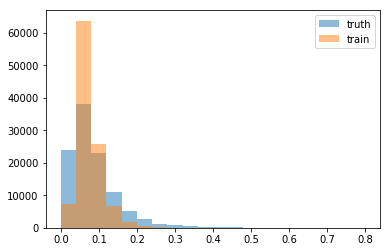

In [59]:
plt.hist(Y, 20, log=False, range=(0, 0.8), alpha=0.5, label='truth')
plt.hist(param_grid[5].y_pred, 20, log=False, range=(0, 0.8), alpha=0.5, label='train')
plt.legend(loc='upper right')
plt.show()

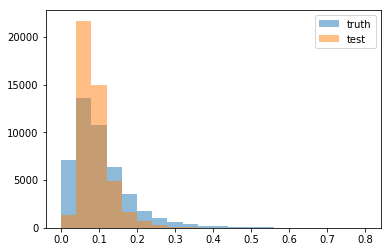

In [58]:
plt.hist(Y_test, 20, log=False, range=(0, 0.8), alpha=0.5, label='truth')
plt.hist(param_grid[2].y_pred_test,20, log=False, range=(0, 0.8), alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.show()

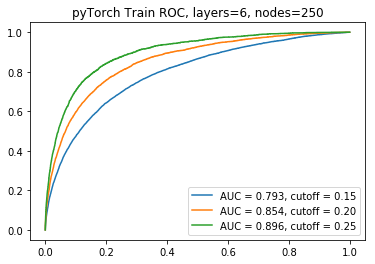

In [60]:
#y_predicted = y_pred.float().detach().numpy()
cutoff = [0.15, 0.2, 0.25]

plt.figure()
for c in cutoff:
    yTrain = np.where(Y > c, 1, 0)
    ypTrain = param_grid[5].y_pred

    auc = sk.metrics.roc_auc_score(yTrain,ypTrain)
    fpr, tpr, _ = sk.metrics.roc_curve(yTrain,ypTrain)

    plt.plot(fpr, tpr, label='AUC = %.3f, cutoff = %0.2f' %(auc, c))

plt.title("pyTorch Train ROC, layers=%i, nodes=%i" %(param_grid[5].layers, param_grid[5].nodes))
plt.legend(loc='lower right')    
plt.show()

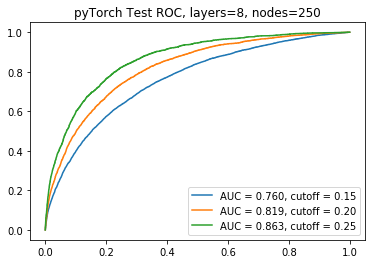

In [61]:
#y_predicted = y_pred.float().detach().numpy()
cutoff = [0.15, 0.2, 0.25]

plt.figure()
for c in cutoff:
    yTest = np.where(Y_test > c, 1, 0)
    ypTest = param_grid[8].y_pred_test

    auc = sk.metrics.roc_auc_score(yTest,ypTest)
    fpr, tpr, _ = sk.metrics.roc_curve(yTest,ypTest)

    plt.plot(fpr, tpr, label='AUC = %.3f, cutoff = %0.2f' %(auc, c))

plt.title("pyTorch Test ROC, layers=%i, nodes=%i" %(param_grid[8].layers, param_grid[8].nodes))
plt.legend(loc='lower right')    
plt.show()

Predict on test sample

In [ ]:
x_test, y_test = Variable(x_test, volatile=True), Variable(y_test)

In [ ]:
#y_pred_test = y_pred_test.detach().numpy()
auc = sk.metrics.roc_auc_score(y_test,y_pred_test)

roc_array = sk.metrics.roc_curve(y_test,y_pred_test)

plt.figure()
plt.plot(roc_array[1], label='AUC = '+str(auc))
plt.title("pytorch test ROC")
plt.legend(loc='lower right')

[[array(0.04884519, dtype=float32), array(0.04902332, dtype=float32), array(0.0491308, dtype=float32), array(0.04975073, dtype=float32)], [array(0.0502816, dtype=float32), array(0.05093752, dtype=float32), array(0.05059234, dtype=float32), array(0.05218538, dtype=float32)], [array(0.04891586, dtype=float32), array(0.04998652, dtype=float32), array(0.04955451, dtype=float32), array(0.04973552, dtype=float32)]]


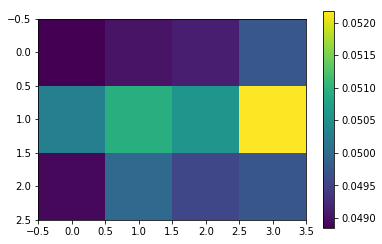

In [83]:
def extents(f):
    delta=f[1]-f[0]
    return [f[0]-delta/2, f[-1]+delta/2]

l_list = [x.layers for x in param_grid]
l_list = list(set(l_list))
n_list = [x.nodes for x in param_grid]
n_list = list(set(n_list))

t_list = []
for n in n_list:
    tmp_list = []
    for p in param_grid:
        if p.nodes==n:
            tmp_list.append(p.test_loss)
    t_list.append(tmp_list)

print(t_list)
plt.imshow(t_list)
plt.colorbar()
plt.show()

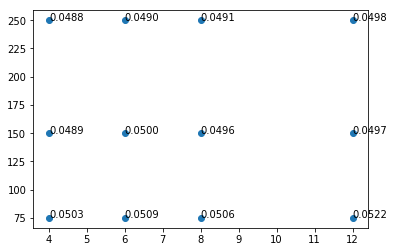

In [94]:
l_vals,n_vals,t_vals = zip(*[(i.layers, i.nodes, i.test_loss) for i in param_grid])
plt.scatter(l_vals,n_vals)#, c=t_vals)
#plt.colorbar()
for i, txt in enumerate(t_vals):
    plt.annotate("%0.4f" %(txt), (l_vals[i],n_vals[i]))